In [47]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt

In [48]:
path = 'Proyecto_RSH_CSV.'

In [49]:
# Definimos los 36 nombres de columna "limpios"
col_limpias = [
    'periodo', 'region', 'comuna', 'unidad_vecinal',
    'n_personas_0_40_pais', 'n_personas_0_40_region', 'n_personas_0_40_comuna', 'n_personas_0_40_uv',
    'n_personas_41_50_pais', 'n_personas_41_50_region', 'n_personas_41_50_comuna', 'n_personas_41_50_uv',
    'n_personas_51_60_pais', 'n_personas_51_60_region', 'n_personas_51_60_comuna', 'n_personas_51_60_uv',
    'n_personas_61_70_pais', 'n_personas_61_70_region', 'n_personas_61_70_comuna', 'n_personas_61_70_uv',
    'n_personas_71_80_pais', 'n_personas_71_80_region', 'n_personas_71_80_comuna', 'n_personas_71_80_uv',
    'n_personas_81_90_pais', 'n_personas_81_90_region', 'n_personas_81_90_comuna', 'n_personas_81_90_uv',
    'n_personas_91_100_pais', 'n_personas_91_100_region', 'n_personas_91_100_comuna', 'n_personas_91_100_uv',
    'total_pais', 'total_region', 'total_comuna', 'total_uv'
]

In [50]:
# El nombre del archivo que dio problemas, puesto que contiene mas de 36 columnas siendo vacias desde la 37
archivo_problematico = "ind_7_87_202306.csv"

archivos = glob.glob(os.path.join(path, "*.csv"))
print(f"Se encontraron {len(archivos)} archivos CSV.")

lista_dfs_limpias = [] # Lista para guardar las tablas LIMPIAS

for archivo in archivos:
    df = None # Reinicia el dataframe

    params = {
        'sep': ';',
        'encoding': 'latin1',
        'header': 2,
        'dtype': {'unidad vecinal': str}
    }
    
    # Si estamos en el archivo problemático, añadimos la regla especial
    if archivo_problematico in archivo:
        print(f"Aplicando (usecols) a: {archivo_problematico}")
        params['usecols'] = range(36)
    
    try:
        df = pd.read_csv(archivo, **params)
            
    except Exception as e1:
        params_nuevos = {
            'sep': ';',
            'encoding': 'utf-8-sig',
            'header': 2,
            'names': col_limpias,
            'dtype': {'unidad_vecinal': str}
        }
        
        if 'usecols' in params:
             params_nuevos['usecols'] = range(36)
             
        try:
            df = pd.read_csv(archivo, **params_nuevos)
            
        except Exception as e2:
            print(f"No se pudo leer el archivo {archivo}. Saltando.")
            continue

    if df.shape[1] == len(col_limpias):
        df.columns = col_limpias
        lista_dfs_limpias.append(df)
    else:
        print(f"--- ALERTA: Archivo {archivo} se leyó con {df.shape[1]} columnas. Descartado.")

print(f"Lectura terminada. Se leyeron {len(lista_dfs_limpias)} de {len(archivos)} archivos correctamente.")

Se encontraron 47 archivos CSV.
Aplicando (usecols) a: ind_7_87_202306.csv
Lectura terminada. Se leyeron 47 de 47 archivos correctamente.


In [51]:
frame = pd.concat(lista_dfs_limpias, axis=0, ignore_index=True)
print("¡Archivos unidos y limpios en la memoria :D!")

¡Archivos unidos y limpios en la memoria :D!


In [52]:
print("--- Primera 5 filas ---")
print()
print(frame.head())
print()
print("--- Últimas 5 columnas ---")
print()
print(frame.tail())
print(f"Forma final (filas, columnas): {frame.shape}")

--- Primera 5 filas ---

   periodo  region  comuna unidad_vecinal  n_personas_0_40_pais  \
0   202308       1    1101         110173               8817093   
1   202308       1    1101         110174               8817093   
2   202308       1    1101         110175               8817093   
3   202308       1    1101         110176               8817093   
4   202308       1    1101         110177               8817093   

   n_personas_0_40_region  n_personas_0_40_comuna n_personas_0_40_uv  \
0                  162848                   76653                242   
1                  162848                   76653                486   
2                  162848                   76653               1221   
3                  162848                   76653               1291   
4                  162848                   76653                740   

   n_personas_41_50_pais  n_personas_41_50_region  ...  \
0                1399906                    23797  ...   
1                139990

In [53]:
frame.to_csv("DATOS_CONSOLIDADOS_RSH.csv", index=False)

print("Se ha creado el archivo 'DATOS_CONSOLIDADOS_RSH.csv'")

Se ha creado el archivo 'DATOS_CONSOLIDADOS_RSH.csv'


In [54]:
# Definimos las columnas que deben ser números
columnas_numericas = [col for col in col_limpias if col.startswith('n_') or col.startswith('total_')]
columnas_uv = [col for col in columnas_numericas if col.endswith('_uv')]
columnas_comuna = [col for col in columnas_numericas if col.endswith('_comuna')]

# Convertimos todo a número ('coerce' convierte "Valores..." en NaN)
# Acá en especial se convierte la columna de "número de personas en tramo 91% - 100% - uv" que contenía 
# "Valores de 1 a 9" el cual se convierte a nulo.
print("Convirtiendo columnas a número...")
for col in columnas_numericas:
    frame.loc[:, col] = pd.to_numeric(frame[col], errors='coerce')

# Rellenamos los vacíos (NaN)
print("Rellenando valores NaN (5 para _uv, 0 para _comuna)...")
frame.loc[:, columnas_uv] = frame[columnas_uv].fillna(5)
frame.loc[:, columnas_comuna] = frame[columnas_comuna].fillna(0)

# Creamos la columna de Fecha (¡AQUÍ ESTÁ EL ARREGLO!)
print("Creando columna 'periodo_dt' para graficar...")
frame.dropna(subset=['periodo'], inplace=True) 

# Convertimos a string y cortamos a 6 caracteres
periodo_str = frame['periodo'].astype(int).astype(str)
periodo_truncado = periodo_str.str.slice(0, 6) # Corta '20250401' a '202504'

# Ahora sí convertimos a fecha
frame.loc[:, 'periodo_dt'] = pd.to_datetime(periodo_truncado, format='%Y%m')

print("\n¡Datos limpios y listos para graficar!")

Convirtiendo columnas a número...
Rellenando valores NaN (5 para _uv, 0 para _comuna)...


/var/folders/zv/wqwzyy8540qfj5jh40j09jr80000gn/T/ipykernel_1197/1294974216.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame.loc[:, columnas_uv] = frame[columnas_uv].fillna(5)
/var/folders/zv/wqwzyy8540qfj5jh40j09jr80000gn/T/ipykernel_1197/1294974216.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  frame.loc[:, columnas_comuna] = frame[columnas_comuna].fillna(0)


Creando columna 'periodo_dt' para graficar...

¡Datos limpios y listos para graficar!


/var/folders/zv/wqwzyy8540qfj5jh40j09jr80000gn/T/ipykernel_1197/132513174.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_para_plotear.plot(


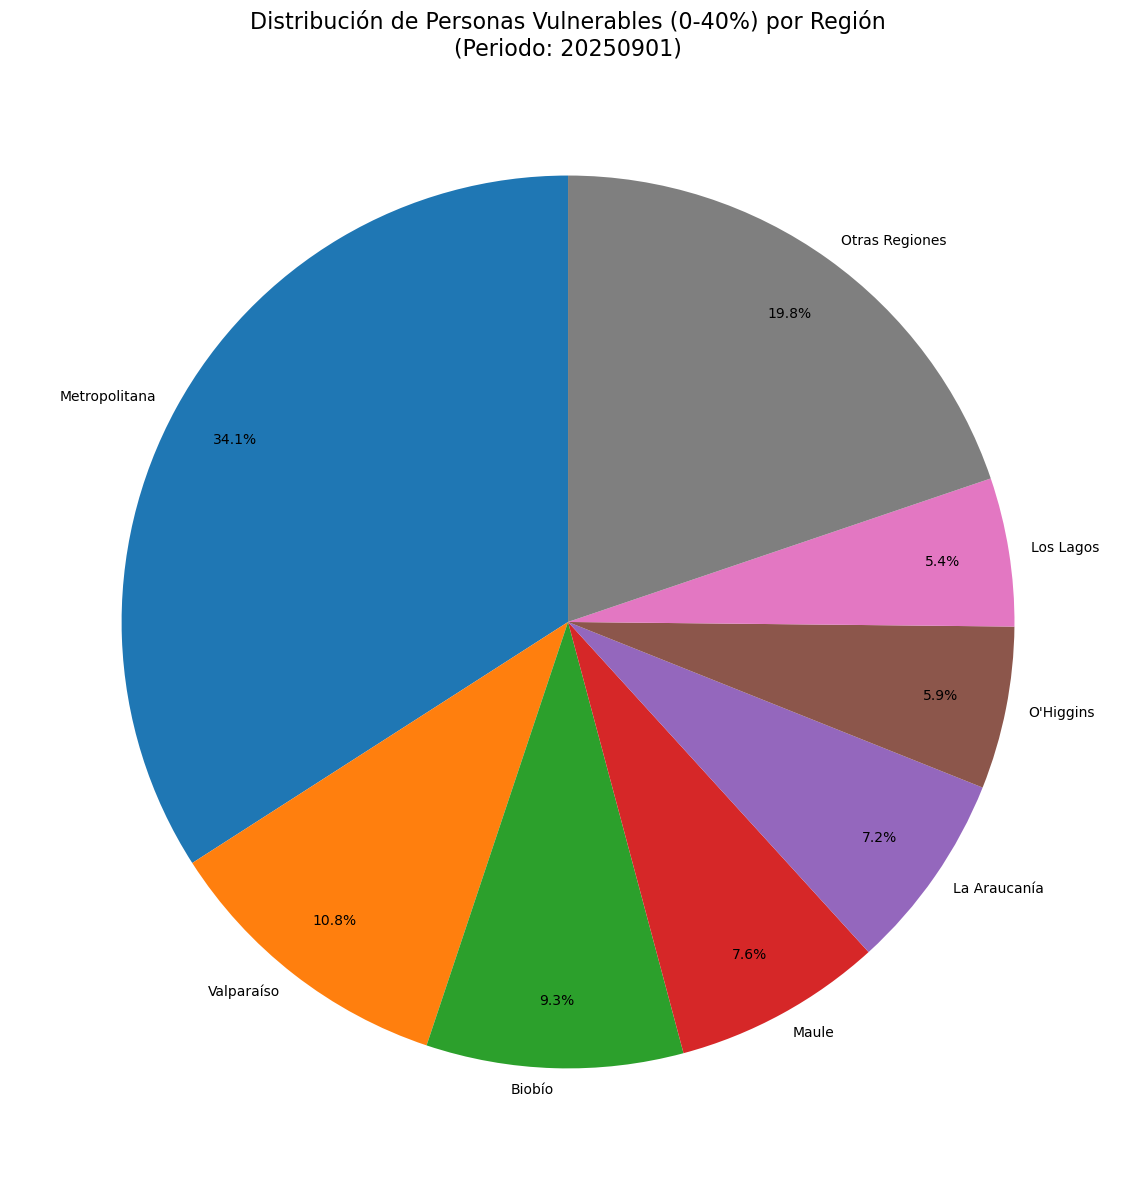

In [55]:
# Creamos el "diccionario" para mapear números a nombres
region_map = {
    1: 'Tarapacá',
    2: 'Antofagasta',
    3: 'Atacama',
    4: 'Coquimbo',
    5: 'Valparaíso',
    6: "O'Higgins",
    7: 'Maule',
    8: 'Biobío',
    9: 'La Araucanía',
    10: 'Los Lagos',
    11: 'Aysén',
    12: 'Magallanes',
    13: 'Metropolitana',
    14: 'Los Ríos',
    15: 'Arica y Parinacota',
    16: 'Ñuble'
}

# Encontramos el último periodo
ultimo_periodo = frame['periodo'].max()
df_reciente = frame[frame['periodo'] == ultimo_periodo].copy()

# Convertimos el número a nombre
# Primero aseguramos que sea un entero
# Luego, usamos .map() para reemplazar el número por el nombre
df_reciente.loc[:, 'region_nombre'] = frame['region'].astype(int).map(region_map)

# Agrupamos por el NUEVO nombre de región
df_regional = df_reciente.groupby('region_nombre')['n_personas_0_40_uv'].sum()

# 5. Top 7 y "Otras"
df_regional = df_regional.sort_values(ascending=False)
top_7 = df_regional.head(7)
otras_regiones = pd.Series([df_regional.iloc[7:].sum()], index=['Otras Regiones'])
df_para_plotear = pd.concat([top_7, otras_regiones])

# 6. Graficar
plt.figure(figsize=(12, 12))
df_para_plotear.plot(
    kind='pie',
    autopct='%1.1f%%',     
    startangle=90,          
    pctdistance=0.85,       
    labeldistance=1.05   
)
plt.title(f"Distribución de Personas Vulnerables (0-40%) por Región\n(Periodo: {ultimo_periodo})", fontsize=16)
plt.ylabel('')
plt.tight_layout()

# Guardamos el gráfico
plt.savefig('regiones_vulnerables.png')
plt.show()

Gráfico 'evolucion_porcentaje_vulnerabilidad.png' guardado.


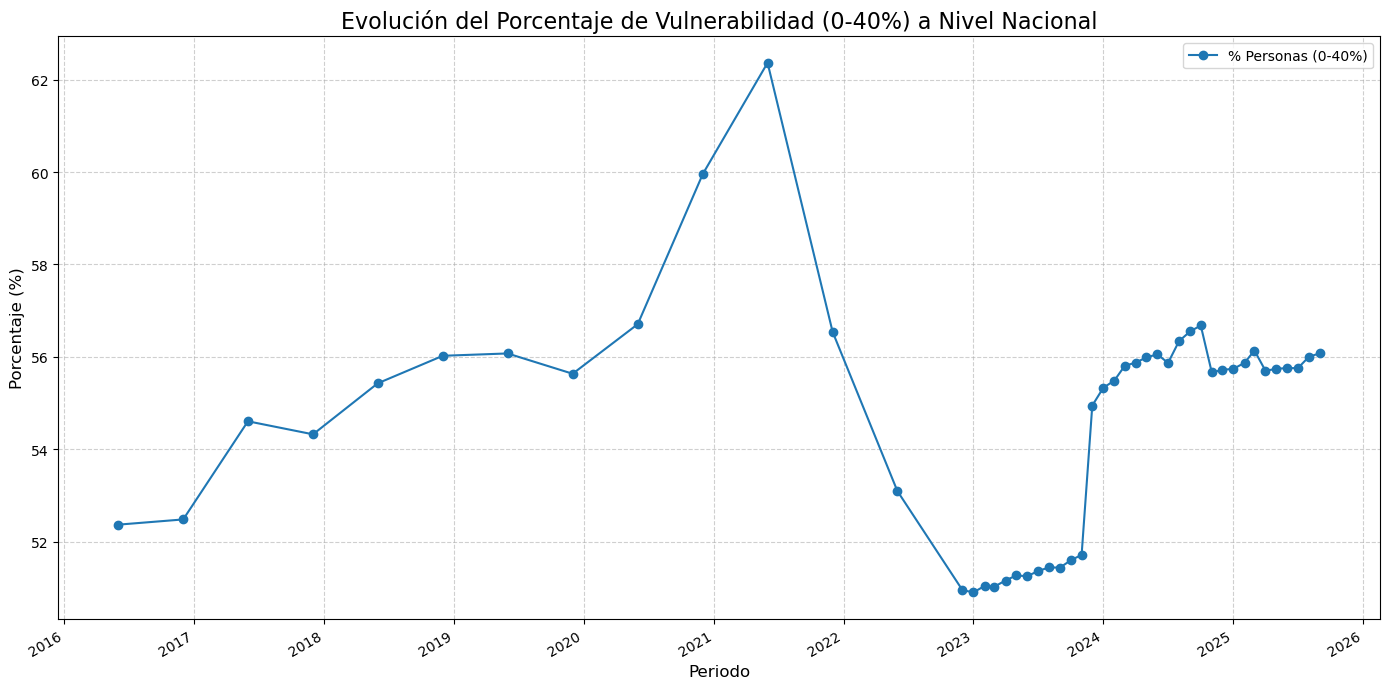

In [56]:
# Agregamos por fecha y sumamos
columnas_a_sumar = ['n_personas_0_40_uv', 'total_uv']
df_agregado = frame.groupby('periodo_dt')[columnas_a_sumar].sum()

# Calculamos el porcentaje
df_agregado['porcentaje_vulnerable_40'] = (df_agregado['n_personas_0_40_uv'] / df_agregado['total_uv']) * 100

# Graficamos
plt.figure(figsize=(14, 7))
df_agregado['porcentaje_vulnerable_40'].plot(
    kind='line', 
    marker='o', 
    linestyle='-',
    label='% Personas (0-40%)'
)

plt.title('Evolución del Porcentaje de Vulnerabilidad (0-40%) a Nivel Nacional', fontsize=16)
plt.xlabel('Periodo', fontsize=12)
plt.ylabel('Porcentaje (%)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('evolucion_porcentaje_vulnerabilidad.png')

print("Gráfico 'evolucion_porcentaje_vulnerabilidad.png' guardado.")
plt.show()